In [26]:
import numpy as np
import pandas as pd
from PIL import Image
import random
import keras
import h5py
import matplotlib.pyplot as plt

In [3]:
# Import the labels
input_directory = "kaggle/input/histopathologic-cancer-detection/"
working_directory = "kaggle/working/"
tmp_directory = "kaggle/temp"
directory = input_directory + "train_labels.csv"
test_data_list = pd.read_csv(directory)
test_data_list.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
#print random images with lablels
samples = test_data_list.iloc[random.sample(range(0,test_data_list.shape[0]), 10)]
#print(samples)
for sample in samples.iterrows():
    #print(sample[1])
    path = input_directory + "train/" + str(sample[1]["id"]) + ".tif"
    if sample[1]["label"] == 0:
        print("Cancer Free")
    else:
        print("Cancerous")
    im = Image.open(path)
    print("Channels: " + str(im.getbands()))
    display(im)


- Cancerous vs Cancer Free numbers in train set
- Size of set
- Find more later

In [ ]:
directory = input_directory + "train/"
print(directory)


In [3]:
def load_and_prodess_image(filename):
    path=input_directory + "train/" + filename + ".tif"
    im = keras.utils.load_img(path, color_mode='rgb', target_size=(32,32))
    return keras.utils.img_to_array(im)/255

test_data_list['image_data'] = test_data_list['id'].apply(load_and_prodess_image)


FileNotFoundError: [Errno 2] No such file or directory: 'kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif'

In [4]:
X = np.stack(test_data_list['image_data'].values)
y = test_data_list['label'].values
path = working_directory + 'image_data.h5'
hdf5_file = path

with h5py.File(hdf5_file, 'w') as f:
    f.create_dataset('images', data=X)
    f.create_dataset('labels', data=y)

KeyError: 'image_data'

In [4]:
path = working_directory + 'image_data.h5'
hdf5_file = path
with h5py.File(hdf5_file, 'r') as f:
    # Load the datasets back into memory
    X = f['images'][:]
    y = f['labels'][:]

In [10]:
# Developed with help from https://keras.io/api/models/model/
inputs = keras.Input(shape=(32,32,3))
def convolution_block(input, filters, dropout_value):
    filters = filters
    kernel_size=(3,3)
    conv1 = keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    ) (inputs)
    conv2 = conv1 = keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation="sigmoid",
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    ) (conv1)
    pool = keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=None, padding="valid", data_format=None, name=None
    )(conv2)
    dropout = keras.layers.Dropout(dropout_value)(pool)
    return dropout
    
def activation_block(input, layer_density, dropout): 
    dense = keras.layers.Dense(layer_density, activation='relu') (input)
    dropout = keras.layers.Dropout(dropout)(dense)
    return dropout

convolution = inputs
for i in range(0,3):
    convolution = convolution_block(convolution, 32, .25)

flatten= keras.layers.Flatten()(convolution)

activation = flatten
for i in range(0,3):
    activation = activation_block(activation,1024,.25)



In [54]:


def run_model(input, learning_rate):
    outputs = keras.layers.Dense(1, activation="sigmoid")(input)
    full_model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    full_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy()])
    history = full_model.fit(
        x=X,
        y=y,
        batch_size=64,
        epochs=10,
        verbose=2,
        callbacks=None,
        validation_split=0.2,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    )
    return full_model, history
    


In [55]:
# Stolen Shamelessly from https://github.com/keras-team/keras/issues/12625 
# Clears up GPU out of memory
from tensorflow.keras import backend as K

# Reset Keras Session
def reset_keras():
    K.clear_session()

def plot_error(train_accuracy, val_accuracy, text):
    epochs = range(1,len(train_accuracy)+1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='blue')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-', color='red')
    title_string = 'Training and Validation Loss' + text
    plt.title(title_string)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/10
2751/2751 - 23s - loss: 0.2668 - binary_accuracy: 0.8907 - val_loss: 0.3863 - val_binary_accuracy: 0.8325 - 23s/epoch - 8ms/step
Epoch 2/10
2751/2751 - 21s - loss: 0.2609 - binary_accuracy: 0.8924 - val_loss: 0.3799 - val_binary_accuracy: 0.8404 - 21s/epoch - 8ms/step
Epoch 3/10
2751/2751 - 21s - loss: 0.2531 - binary_accuracy: 0.8954 - val_loss: 0.4057 - val_binary_accuracy: 0.8364 - 21s/epoch - 8ms/step
Epoch 4/10
2751/2751 - 21s - loss: 0.2614 - binary_accuracy: 0.8924 - val_loss: 0.4278 - val_binary_accuracy: 0.8248 - 21s/epoch - 8ms/step
Epoch 5/10
2751/2751 - 21s - loss: 0.2499 - binary_accuracy: 0.8974 - val_loss: 0.4446 - val_binary_accuracy: 0.8341 - 21s/epoch - 8ms/step
Epoch 6/10
2751/2751 - 21s - loss: 0.2475 - binary_accuracy: 0.8982 - val_loss: 0.4251 - val_binary_accuracy: 0.8448 - 21s/epoch - 8ms/step
Epoch 7/10
2751/2751 - 21s - loss: 0.2502 - binary_accuracy: 0.8977 - val_loss: 0.4015 - val_binary_accuracy: 0.8409 - 21s/epoch - 8ms/step
Epoch 8/10
2751/2751

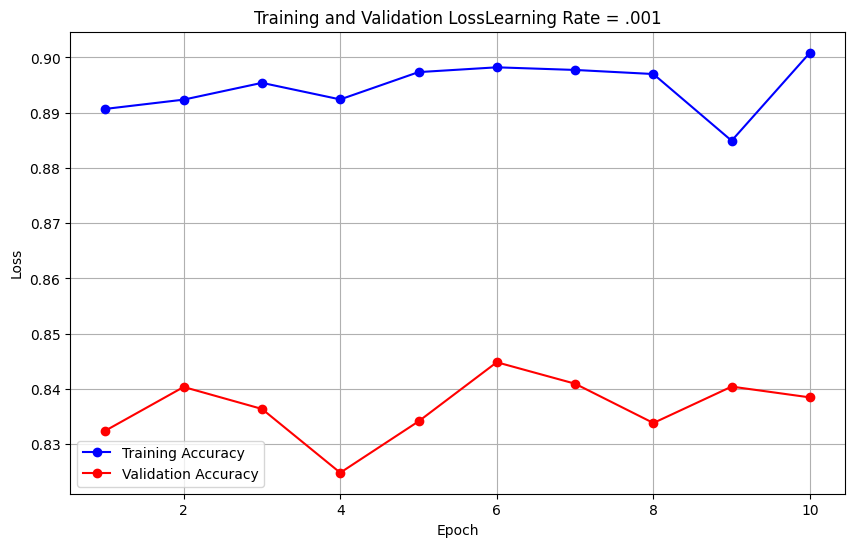

In [56]:
nothing, history = run_model(activation, .001)
text = "Learning Rate = .001"
plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
reset_keras()

This is showing a fluctuating test error rate.  I'm going to try to tune down the learning rate to fix this jumping around.  This does indicate that the test data is probably as good as it gets for this model though.  I reran this model with learning rates of .0005, .00025, and .0001

In [ ]:
lr = [.0005, .00025, .0001]
for rate in lr:
    text = "Learning Rate " + str(rate)
    print(text)
    _, history = run_model(activation, .0005)
    plot_error(history.history["binary_accuracy"], history.history["val_binary_accuracy"], text)
    reset_keras()
    


Based on these results, I thing the .0001 learning rate is the best option.  I will continue with this until I see a need for a higher rate.